In [71]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install pyod
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install catboost 
!{sys.executable} -m pip install plotly 
!{sys.executable} -m pip install seaborn 
!{sys.executable} -m pip install nltk 

In [91]:
import glob
import time
import pandas as pd
import numpy as np
# from xml.dom import minidom
from nltk import ngrams
from nltk.tokenize import sent_tokenize
import nltk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score


import re
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.snowball import SnowballStemmer

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [92]:
df = pd.read_csv("Dataset/RowDataSetTest.csv")
df.head()

,Id,PostTypeId,AcceptedAnswerId,creationDate,CurrentDate,Days,Score,ViewCount,Body,LastActivityDate,Title,Tags,AnswerCount,CommentCount,Class
0,40586,1,40593.0,2/9/2008,23-10-2020,4434,2,2948,"<p>In a try/except block, how do I extract the...",11/22/2016 6:58,cx_Oracle: how do I get the ORA-xxxxx error nu...,<python><oracle><cx-oracle>,1,0,0
1,16094747,1,16095170.0,18-04-2013,23-10-2020,2745,4,18417,<p>I am facing the below oracle error for the ...,4/19/2013 1:24,format code appears twice error while insertin...,<c#><oracle><datetime><insert-query>,1,2,1
2,16104218,1,16104302.0,19-04-2013,23-10-2020,2744,13,16907,<p>I'm doing something like</p>\n\n<pre><code>...,11/12/2014 8:41,ORA-01745 error while executing parameterized ...,<c#><.net><oracle>,2,6,1
3,16165438,1,NaN,23-04-2013,23-10-2020,2740,1,55,<p>When I try to execute below query im gettin...,4/23/2013 9:33,Dynamic Query error,<plsql><oracle11g>,1,1,0
4,32228719,1,NaN,26-08-2015,23-10-2020,1885,1,303,<p>Having the weirdest problem ever. I do have...,8/28/2015 8:30,Missing comma error error inserting sql throug...,<sql><vba><ms-access><oracle11g><ms-access-2007>,1,4,0


Text(0.5, 1.0, 'Ratio of missing values per columns')

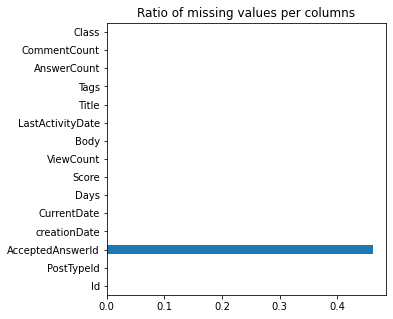

In [93]:
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [94]:


tokenizer = ToktokTokenizer()
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

In [95]:
def remove_html(text):
    # Remove html and convert to lowercase
    return re.sub(r"\<[^\>]\>", "", text).lower()

def remove_stopwords(text):    
    # tokenize the text
    words = tokenizer.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

def remove_punc(text):
    #tokenize
    tokens = tokenizer.tokenize(text)
    
    # remove punctuations from each token
    tokens = list(map(lambda token: re.sub(r"[^A-Za-z0-9]+", " ", token).strip(), tokens))
    
    # remove empty strings from tokens
    tokens = list(filter(lambda token: token, tokens))
    
    return ' '.join(map(str, tokens))

def stem_text(text):
    #tokenize
    tokens = tokenizer.tokenize(text)
    
    # stem each token
    tokens = list(map(lambda token: stemmer.stem(token), tokens))
    
    return ' '.join(map(str, tokens))


In [96]:
%%time
# apply preprocessing to title and body
## Remove puntuation and preposition from text(title and body)
df['Title'] = df['Title'].apply(lambda x: remove_html(x))
df['Title'] = df['Title'].apply(lambda x: remove_stopwords(x))
df['Title'] = df['Title'].apply(lambda x: remove_punc(x))
df['Title'] = df['Title'].apply(lambda x: stem_text(x))

Wall time: 83 ms


In [97]:
%%time
# apply preprocessing to title and body
df['Body'] = df['Body'].apply(lambda x: remove_html(x))
df['Body'] = df['Body'].apply(lambda x: remove_stopwords(x))
df['Body'] = df['Body'].apply(lambda x: remove_punc(x))
df['Body'] = df['Body'].apply(lambda x: stem_text(x))


Wall time: 1.26 s


In [98]:
vectorizer_title = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=4)

In [99]:
vectorizer_body = TfidfVectorizer(
                                    analyzer = 'word', 
                                    strip_accents = None, 
                                    encoding = 'utf-8', 
                                    preprocessor=None, 
                                    max_features=10)

In [100]:
vectorizer = CountVectorizer( min_df=2, max_df=0.7, stop_words=stopwords.words('english'))
 
texttile = vectorizer.fit_transform(df['Title'].values.astype('U')).toarray()
textbody = vectorizer.fit_transform(df['Body'].values.astype('U')).toarray()
# print(posts)

texttile=pd.DataFrame(texttile)

textbody=pd.DataFrame(textbody)


df=pd.concat([df,texttile,textbody],axis=1)

In [101]:
## Remove less important features
df = df.drop(['Body', 'Title','Tags','creationDate','LastActivityDate','CurrentDate','AcceptedAnswerId'],axis = 1,inplace=False)

## Scalling column using RobustScaler
df['Id'] = RobustScaler().fit_transform(df['Id'].values.reshape(-1,1))
df['PostTypeId'] = RobustScaler().fit_transform(df['PostTypeId'].values.reshape(-1,1))
#df['creationDate'] = RobustScaler().fit_transform(df['creationDate'].values.reshape(-1,1))
df['Days'] = RobustScaler().fit_transform(df['Days'].values.reshape(-1,1))
df['Score'] = RobustScaler().fit_transform(df['Score'].values.reshape(-1,1))
df['ViewCount'] = RobustScaler().fit_transform(df['ViewCount'].values.reshape(-1,1))
#df['LastActivityDate'] = RobustScaler().fit_transform(df['LastActivityDate'].values.reshape(-1,1))
#df['Tags'] = RobustScaler().fit_transform(df['Tags'].values.reshape(-1,1))
df['AnswerCount'] = RobustScaler().fit_transform(df['AnswerCount'].values.reshape(-1,1))
df['CommentCount'] = RobustScaler().fit_transform(df['CommentCount'].values.reshape(-1,1))


In [102]:
## training and testing dataset devide
# Class count
# Define the prep_data function to extrac features 
def prep_data(df):
    X = df.drop(['Class'],axis=1, inplace=False)  
    X = np.array(X).astype(np.float)
    y = df[['Class']]  
    y = np.array(y).astype(np.float)
    return X,y



In [103]:
df

,Id,PostTypeId,Days,Score,ViewCount,AnswerCount,CommentCount,Class,0,1,...,2115,2116,2117,2118,2119,2120,2121,2122,2123,2124
0,-0.697477,0.0,1.203822,0.5,0.270477,0.0,-0.333333,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.130830,0.0,0.128025,1.5,3.015884,0.0,0.333333,1,0,0,...,0,0,0,0,0,0,3,0,0,0
2,-0.130496,0.0,0.127389,6.0,2.747892,1.0,1.666667,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.128335,0.0,0.124841,0.0,-0.242967,0.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.438634,0.0,-0.419745,0.0,-0.198953,0.0,1.000000,0,0,0,...,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,-0.393435,0.0,0.431847,0.0,-0.242790,0.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0.495880,0.0,-0.475796,0.0,-0.158133,0.0,0.666667,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,-0.077737,0.0,0.074522,2.0,8.452746,0.0,1.333333,1,0,0,...,0,0,0,0,0,0,0,1,0,0
397,-0.353413,0.0,0.378981,1.5,1.264354,1.0,-0.333333,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
# Create X and y from the prep_data function 
X, y = prep_data(df)
y= y.astype(np.int64)

In [105]:
# Apply different ML Classification Algorithm

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

In [106]:
# ****** LogisticRegression Accuration test
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\tools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [120]:
# confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[70,  0],
       [ 3,  7]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

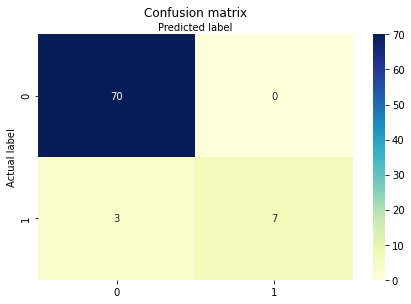

In [125]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

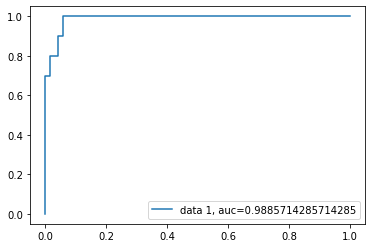

In [124]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [130]:
# instantiate classifier with default hyperparameters
clf = SVC(probability=True)
clf.fit(X_train, y_train)
y_predsvm = clf.predict(X_test)


C:\tools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Text(0.5, 257.44, 'Predicted label')

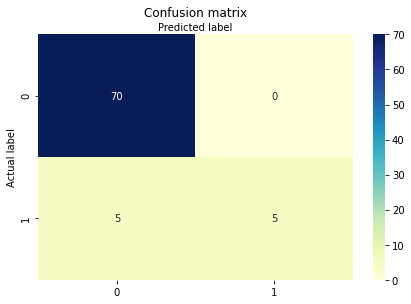

In [131]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_predsvm)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

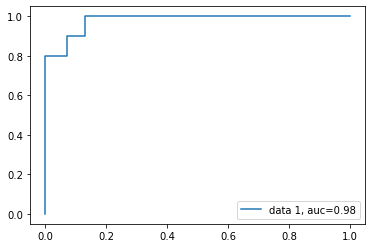

In [134]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [108]:
##LogisticRegression  Machine learning evaluation matrix
accuracy = accuracy_score(y_test, y_pred)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
pre_scor= precision_score(y_test, y_pred)
re_scor = recall_score(y_test, y_pred)
f1_scor = f1_score(y_test, y_pred)

In [109]:
## Random forest classifier algorithm
#Create a Gaussian Classifier
rfclf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
rfclf.fit(X_train, y_train)
y_pred_rf=rfclf.predict(X_test)
## Random Forest Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision= precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)


<ipython-input-109-e77ce5ca8c56>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclf.fit(X_train, y_train)


Text(0.5, 257.44, 'Predicted label')

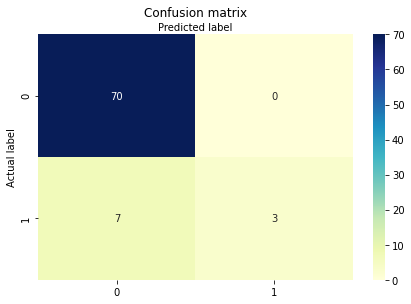

In [135]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

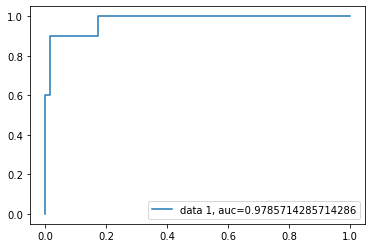

In [136]:
y_pred_proba = rfclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [110]:
## Decision Tree Classifier algorithm
# Create Decision Tree classifer object
dtclf = DecisionTreeClassifier()
# Train Decision Tree Classifer
dtclf = dtclf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred_dt = dtclf.predict(X_test)

## Decision Tree Evaluation
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision= precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

Text(0.5, 257.44, 'Predicted label')

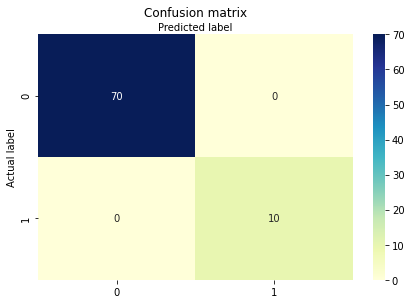

In [137]:
import seaborn as sns
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred_dt)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

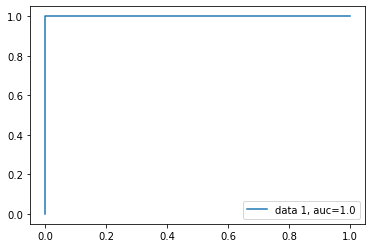

In [138]:
y_pred_proba = dtclf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [111]:
print("==================== Logistic Regression Evaluation Score ======================")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("\n Precision Score:  %.2f%%" % (pre_scor * 100.0))
print("\n Recall Score:  %.2f%%" % (re_scor * 100.0))
print('\n F1-Measure: %.2f%%' % (f1_scor * 100.0))

print("=============End Evaluation ===============================")

==================== Logistic Regression Evaluation Score ======================
Accuracy: 96.25%

 Precision Score:  100.00%

 Recall Score:  70.00%

 F1-Measure: 82.35%
=============End Evaluation ===============================


In [112]:
## SVM Algorithm Apply
accuracy = accuracy_score(y_test, y_predsvm)
pre_scor= precision_score(y_test, y_predsvm)
re_scor = recall_score(y_test, y_predsvm)
f1_scor = f1_score(y_test, y_predsvm)

In [113]:
print("==================== SVM Evaluation Algorithm ======================")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("\n Precision Score:  %.2f%%" % (pre_scor * 100.0))
print("\n Recall Score:  %.2f%%" % (re_scor * 100.0))
print('\n F1-Measure: %.2f%%' % (f1_scor * 100.0))

print("=============End Evaluation ===============================")


==================== SVM Evaluation Algorithm ======================
Accuracy: 93.75%

 Precision Score:  100.00%

 Recall Score:  50.00%

 F1-Measure: 66.67%
=============End Evaluation ===============================


In [114]:

print("==================== Random Forest Classifier Algorithm ======================")
print("Accuracy: %.2f%%" % (rf_accuracy * 100.0))
print("\n Precision Score:  %.2f%%" % (rf_precision * 100.0))
print("\n Recall Score:  %.2f%%" % (rf_recall * 100.0))
print('\n F1-Measure: %.2f%%' % (rf_f1 * 100.0))

==================== Random Forest Classifier Algorithm ======================
Accuracy: 91.25%

 Precision Score:  100.00%

 Recall Score:  30.00%

 F1-Measure: 46.15%


In [115]:
print("==================== Decision Tree Classifier Algorithm ======================")
print("Accuracy: %.2f%%" % (dt_accuracy * 100.0))
print("\n Precision Score:  %.2f%%" % (dt_precision * 100.0))
print("\n Recall Score:  %.2f%%" % (dt_recall * 100.0))
print('\n F1-Measure: %.2f%%' % (dt_f1 * 100.0))

==================== Decision Tree Classifier Algorithm ======================
Accuracy: 100.00%

 Precision Score:  100.00%

 Recall Score:  100.00%

 F1-Measure: 100.00%
